In [17]:
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from lsmm_data import LSMMData
import json
from tqdm import tqdm

with open('pyr_chains.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings


# Generate the chain results
# Assembly chain results (no no-a cells exist in their graph)
# Make a graph of just excitatory cells
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
synapse_table = data_a['structural']['synapse']
adjacency_matrix = data_a['structural']['binary_connectome']
pyr_graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)


## Uncomment below to load existing chain motif analysis results
# two_chain_results_array = np.load('all_cell_two_chain_results_array.npy')
# three_chain_results_array = np.load('all_cell_three_chain_results_array.npy')
# four_chain_results_array = np.load('all_cell_four_chain_results_array.npy')

## Or uncomment below to generate new motif analysis results (Can take quite a while on larger graphs)
# Motif Analysis with DotMotif: 2 Chain, All Pyr
executor = GrandIsoExecutor(graph=pyr_graph)
chain_defs = Motif("""
                A -> B
              """)

chain_results = executor.find(chain_defs)
two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])

# Motif Analysis with DotMotif: 3 Chain, All Pyr
executor = GrandIsoExecutor(graph=pyr_graph)
chain_defs = Motif("""
                A -> B
                B -> C
              """)
chain_results = executor.find(chain_defs)
three_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])

# Motif Analysis with DotMotif: 4 Chain, All Pyr
executor = GrandIsoExecutor(graph=pyr_graph)
chain_defs = Motif("""
                A -> B
                B -> C
                C -> D
              """)
chain_results = executor.find(chain_defs)
four_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])
assembly_chain_results_arrays = [two_chain_results_array, three_chain_results_array, four_chain_results_array]

chain_count_string_array = ['pyr_cell_2chain', 'pyr_cell_3chain', 'pyr_cell_4chain']
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)] # JULIAN EDIT: added all assemblies, doesn't change anything

coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
pooled_assembly_indexes = [list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))]

# print('Assembly Root IDs:', list(set(mappings_a['assemblies_by_pt_root_id'].keys()) - set(mappings_a['pt_root_ids_by_assembly']['No A'])))
# print('NonAssembly Root IDs:', mappings_a['pt_root_ids_by_assembly']['No A'])

scaling_factors_two = [(len(individual_assembly_indexes[i])-1) for i in range(15)] # JULIAN EDIT: extended list to all possible assemblies, doesn't change anything
scaling_factors_three = [(len(individual_assembly_indexes[i])-1) * (len(data_a['structural']['pre_cell'])-2) for i in range(15)]
scaling_factors_four = [(len(individual_assembly_indexes[i])-1) * (len(data_a['structural']['pre_cell'])-2) * (len(data_a['structural']['pre_cell'])-3) for i in range(15)]
scaling_factors_lists = [scaling_factors_two, scaling_factors_three, scaling_factors_four]

no_a_scaling_factors_two = (len(no_a_cell_indexes)-1)
no_a_scaling_factors_three = (len(no_a_cell_indexes)-1)  * (len(data_a['structural']['pre_cell'])-2)
no_a_scaling_factors_four = (len(no_a_cell_indexes)-1)  * (len(data_a['structural']['pre_cell'])-2) * (len(data_a['structural']['pre_cell'])-3)
no_a_scaling_factors = [no_a_scaling_factors_two, no_a_scaling_factors_three, no_a_scaling_factors_four]

# # JULIAN EDIT: Trying out if you produce a probability count
# scaling_factors_two = [len(individual_assembly_indexes[i]) * (len(individual_assembly_indexes[i])-1) for i in range(15)]
# scaling_factors_three = [len(individual_assembly_indexes[i]) * (len(individual_assembly_indexes[i])-1) * (len(data_a['structural']['pre_cell'])-2) for i in range(15)]
# scaling_factors_four = [len(individual_assembly_indexes[i]) * (len(individual_assembly_indexes[i])-1) * (len(data_a['structural']['pre_cell'])-2) * (len(data_a['structural']['pre_cell'])-3) for i in range(15)]
# scaling_factors_lists = [scaling_factors_two, scaling_factors_three, scaling_factors_four]

# no_a_scaling_factors_two = len(no_a_cell_indexes) * (len(no_a_cell_indexes)-1)
# no_a_scaling_factors_three = len(no_a_cell_indexes) * (len(no_a_cell_indexes)-1)  * (len(data_a['structural']['pre_cell'])-2)
# no_a_scaling_factors_four = len(no_a_cell_indexes) * (len(no_a_cell_indexes)-1)  * (len(data_a['structural']['pre_cell'])-2) * (len(data_a['structural']['pre_cell'])-3)
# no_a_scaling_factors = [no_a_scaling_factors_two, no_a_scaling_factors_three, no_a_scaling_factors_four]



Generating Connectome...


100%|██████████| 4565/4565 [00:00<00:00, 14953.33it/s]


Generating Connectome...


100%|██████████| 309885/309885 [00:00<00:00, 1129384.28it/s]


In [18]:
# # Intra-Assembly to Intra-Assembly chains, assemblies with 5 or more cells
# # with scaling and filtering of no-a cells from assembly chains
# # Individual and pooled results.  Assembly and non-assembly.

multi_length_chain_participation_by_coregistered_cell_pair = {}

for i in range(3):
    chain_results_array = assembly_chain_results_arrays[i]
    title = chain_count_string_array[i]

    # Get chain participation
    chain_participation_by_coregistered_cell_pair = {}
    for index1 in tqdm(coregistered_cell_indexes):
        if index1 not in chain_participation_by_coregistered_cell_pair.keys():
                chain_participation_by_coregistered_cell_pair[index1] = {}
        if index1 not in multi_length_chain_participation_by_coregistered_cell_pair.keys():
                multi_length_chain_participation_by_coregistered_cell_pair[index1] = {}
        for index2 in coregistered_cell_indexes: ### JULIAN COMMENT: SHOULD WE BE HANDLING THE CASE WHERE (index1 == index2), loops, or does dotmotif do that automatically?
            if index2 not in chain_participation_by_coregistered_cell_pair[index1].keys():
                chain_participation_by_coregistered_cell_pair[index1][index2] = 0
            if index2 not in multi_length_chain_participation_by_coregistered_cell_pair[index1].keys():
                multi_length_chain_participation_by_coregistered_cell_pair[index1][index2] = 0
            temp = np.where(np.logical_and(chain_results_array[:,0] == index1, chain_results_array[:,-1] == index2))[0].size
            chain_participation_by_coregistered_cell_pair[index1][index2] += temp
            multi_length_chain_participation_by_coregistered_cell_pair[index1][index2] += temp


# Pool all chain lengths
# Pool cells which are in assemblies
assembly_allchain_pooled_assembly_cell_participation = []
# allchain_pooled_per_item_scaling_factors = []
for chain_length_index in range(3):
    # scaling_factors = scaling_factors_lists[chain_length_index]
    for a_index in [0, 1, 2, 3, 4, 5, 7, 9]:
        scaling_factor = scaling_factors_lists[chain_length_index][a_index]
        if scaling_factor > 0:
            for index in individual_assembly_indexes[a_index]:
                for index2 in individual_assembly_indexes[a_index]:            
                    assembly_allchain_pooled_assembly_cell_participation.append(multi_length_chain_participation_by_coregistered_cell_pair[index1][index2] / scaling_factor)                         


no_a_allchain_pooled_assembly_cell_participation = []
# allchain_pooled_per_item_scaling_factors = []
for chain_length_index in range(3):
    scaling_factor = no_a_scaling_factors[chain_length_index]
    if scaling_factor > 0:
        for index in no_a_cell_indexes:
            for index2 in no_a_cell_indexes:            
                no_a_allchain_pooled_assembly_cell_participation.append(multi_length_chain_participation_by_coregistered_cell_pair[index1][index2] / scaling_factor)                         



100%|██████████| 55/55 [00:00<00:00, 58.14it/s]


[0.35, 0.0, 0.1, 0.1, 0.2, 0.1, 0.0, 0.05, 0.05, 0.15, 0.0, 0.0, 0.1, 0.0, 0.05, 0.0, 0.15, 0.1, 0.0, 0.1, 0.1, 0.35, 0.0, 0.1, 0.1, 0.2, 0.1, 0.0, 0.05, 0.05, 0.15, 0.0, 0.0, 0.1, 0.0, 0.05, 0.0, 0.15, 0.1, 0.0, 0.1, 0.1, 0.35, 0.0, 0.1, 0.1, 0.2, 0.1, 0.0, 0.05, 0.05, 0.15, 0.0, 0.0, 0.1, 0.0, 0.05, 0.0, 0.15, 0.1, 0.0, 0.1, 0.1, 0.35, 0.0, 0.1, 0.1, 0.2, 0.1, 0.0, 0.05, 0.05, 0.15, 0.0, 0.0, 0.1, 0.0, 0.05, 0.0, 0.15, 0.1, 0.0, 0.1, 0.1, 0.35, 0.0, 0.1, 0.1, 0.2, 0.1, 0.0, 0.05, 0.05, 0.15, 0.0, 0.0, 0.1, 0.0, 0.05, 0.0, 0.15, 0.1, 0.0, 0.1, 0.1, 0.35, 0.0, 0.1, 0.1, 0.2, 0.1, 0.0, 0.05, 0.05, 0.15, 0.0, 0.0, 0.1, 0.0, 0.05, 0.0, 0.15, 0.1, 0.0, 0.1, 0.1, 0.35, 0.0, 0.1, 0.1, 0.2, 0.1, 0.0, 0.05, 0.05, 0.15, 0.0, 0.0, 0.1, 0.0, 0.05, 0.0, 0.15, 0.1, 0.0, 0.1, 0.1, 0.35, 0.0, 0.1, 0.1, 0.2, 0.1, 0.0, 0.05, 0.05, 0.15, 0.0, 0.0, 0.1, 0.0, 0.05, 0.0, 0.15, 0.1, 0.0, 0.1, 0.1, 0.35, 0.0, 0.1, 0.1, 0.2, 0.1, 0.0, 0.05, 0.05, 0.15, 0.0, 0.0, 0.1, 0.0, 0.05, 0.0, 0.15, 0.1, 0.0, 0.1, 0.1, 

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa35b953310>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa35b953730>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa35b953070>,
 'medians': [<matplotlib.lines.Line2D at 0x7fa35b953c70>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa35b953f10>,
 'means': []}

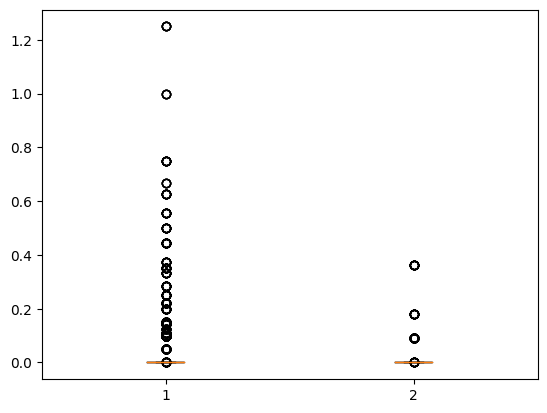

In [20]:
# Now Compare the two
print(assembly_allchain_pooled_assembly_cell_participation)
print(no_a_allchain_pooled_assembly_cell_participation)

import scipy.stats as stats

# Perform Wilcoxon Rank Sum Test
print(f'Wilcoxon Rank Sum Test: \n\tAll pyr chain lengths, intra-assembly, normalized by possible chains\n\tvs All pyr chain lengths, intra-nonassembly, normalized by possible chains')
print('A vs No A')
print(stats.ranksums(assembly_allchain_pooled_assembly_cell_participation, no_a_allchain_pooled_assembly_cell_participation, alternative='greater'))

print(np.mean(assembly_allchain_pooled_assembly_cell_participation), np.median(assembly_allchain_pooled_assembly_cell_participation))
print(np.mean(no_a_allchain_pooled_assembly_cell_participation), np.median(no_a_allchain_pooled_assembly_cell_participation))

plt.figure()
plt.box
plt.boxplot([assembly_allchain_pooled_assembly_cell_participation, no_a_allchain_pooled_assembly_cell_participation])
#plt.savefig(f'chains/pyr_all_chain_lengths_intra_pooled.png')


In [ ]:
0.004549620129948265 3.42760621466138e-08
0.002319891163092918 3.6353399246408574e-08